#### Stop any previous spark session that might be running 

In [1]:
try:
    sc.stop()
except:
    pass

#### Start a new spark session

In [2]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("sparkml Decision Tree").setMaster('local[4]')
sc = SparkContext.getOrCreate(conf = conf)

from pyspark.sql import SparkSession

# IMport library that will allow me to typecast into data types 
from pyspark.sql.types import StructField, StringType, IntegerType, StructType

spark = SparkSession.builder.appName('pyspark decision tree session').getOrCreate()

#### Import necessary libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pyspark.sql.functions import *

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


US Income an individual’s annual income influenced from various factors. Intuitively, it is influenced by the individual’s education level, age, gender, occupation, and etc.
The dataset contains 16 columns
Target filed: Income
The income is divided into two classes: 50K
Number of attributes: 14
Dataset: adult.csv

Create Prediction of Income >=50K or <50K using Logistic Regression Classification and Decision Tree Classifier model. Display classification Metrics and compare both algorithm’s which one gives better results Classification Report, Accuracy and Confusion Matrix. Make new predictions using best model from both of these.


#### Load dataset from local drive

In [4]:
adult_df = spark.read.csv('file:///home/hadoop/Downloads/adult.csv', header=True, inferSchema=True)
adult_df.show(5)

+---+---------+------+------------+---------------+------------------+-----------------+------------+-----+------+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|   education|educational-num|    marital-status|       occupation|relationship| race|gender|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+---------+------+------------+---------------+------------------+-----------------+------------+-----+------+------------+------------+--------------+--------------+------+
| 25|  Private|226802|        11th|              7|     Never-married|Machine-op-inspct|   Own-child|Black|  Male|           0|           0|            40| United-States| <=50K|
| 38|  Private| 89814|     HS-grad|              9|Married-civ-spouse|  Farming-fishing|     Husband|White|  Male|           0|           0|            50| United-States| <=50K|
| 28|Local-gov|336951|  Assoc-acdm|             12|Married-civ-spouse|  Protective-serv|     Husband|White|  M

#### Load data into cache for faster processing

In [5]:
adult_df.cache()

DataFrame[age: int, workclass: string, fnlwgt: int, education: string, educational-num: int, marital-status: string, occupation: string, relationship: string, race: string, gender: string, capital-gain: int, capital-loss: int, hours-per-week: int, native-country: string, income: string]

#### A look at the datatypes we have

In [6]:
adult_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)



#### Statistics summary of the features

In [7]:
adult_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,48842,38.64358543876172,13.710509934443518,17,90
workclass,48842,None,None,?,Without-pay
fnlwgt,48842,189664.13459727284,105604.02542315758,12285,1490400
education,48842,None,None,10th,Some-college
educational-num,48842,10.078088530363212,2.570972755592256,1,16
marital-status,48842,None,None,Divorced,Widowed
occupation,48842,None,None,?,Transport-moving
relationship,48842,None,None,Husband,Wife
race,48842,None,None,Amer-Indian-Eskimo,White


#### Data Cleaning

In [9]:
adult_df = adult_df.withColumn("workclass", when(adult_df.workclass == '?', np.nan).otherwise(adult_df.workclass))
adult_df = adult_df.withColumn("occupation", when(adult_df.occupation == '?', np.nan).otherwise(adult_df.occupation))
adult_df = adult_df.withColumn("native-country", when(adult_df['native-country'] == '?', np.nan).otherwise(adult_df['native-country']))

#### A check for null values

In [10]:
adult_df.select([count(when(isnan(c), c)).alias(c) for c in adult_df.columns]).show()

+---+---------+------+---------+---------------+--------------+----------+------------+----+------+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|education|educational-num|marital-status|occupation|relationship|race|gender|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+---------+------+---------+---------------+--------------+----------+------------+----+------+------------+------------+--------------+--------------+------+
|  0|     2799|     0|        0|              0|             0|      2809|           0|   0|     0|           0|           0|             0|           857|     0|
+---+---------+------+---------+---------------+--------------+----------+------------+----+------+------------+------------+--------------+--------------+------+



#### EDA of target variable

+------+-----+
|income|count|
+------+-----+
|  null|   10|
| <=50K|37123|
|  >50K|11681|
+------+-----+

+------+------+-----+
|gender|income|count|
+------+------+-----+
|  Male| <=50K|22713|
|  null|  null|   10|
|  Male|  >50K| 9913|
|Female| <=50K|14410|
|Female|  >50K| 1768|
+------+------+-----+



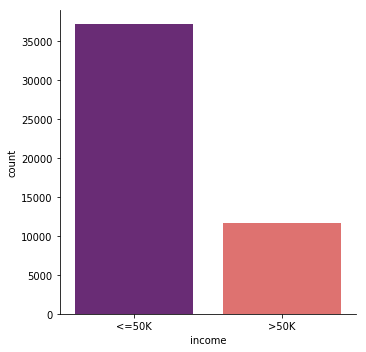

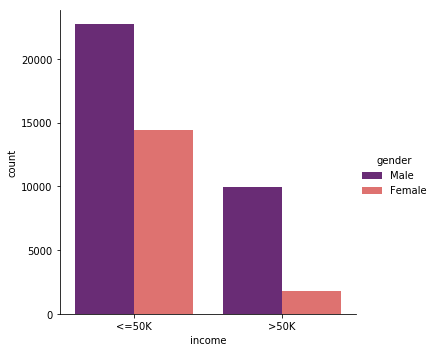

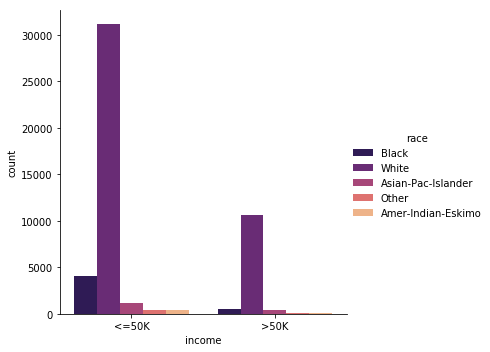

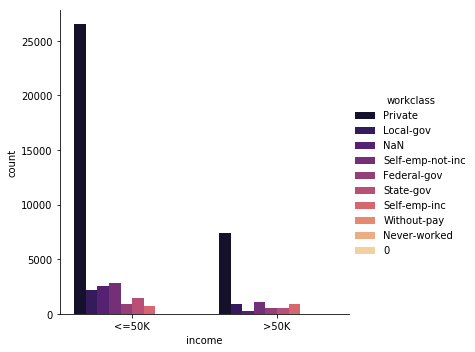

In [11]:
# Count of income which are >=50k and <=50k
adult_df.groupby("income").count().show()
sns.catplot(x = "income", kind = "count", data = adult_df.toPandas(), palette='magma')
adult_df.groupby("gender", "income").count().show()
sns.catplot(x = "income", kind = "count", data = adult_df.toPandas(), hue = 'gender', palette='magma')

sns.catplot(x = "income", kind = "count", data = adult_df.toPandas(), hue = 'race', palette='magma')
sns.catplot(x = "income", kind = "count", data = adult_df.toPandas(), hue = 'workclass', palette='magma')

#### Converting string entries to numbers

In [11]:
indexers = [StringIndexer(inputCol = column, outputCol=column+"_index").fit(adult_df) for column in ["workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country", "income"]]
pipeline = Pipeline(stages=indexers)
adult_df = pipeline.fit(adult_df).transform(adult_df)

In [12]:
adult_df.columns

['age',
 'workclass',
 'fnlwgt',
 'education',
 'educational-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'income',
 'workclass_index',
 'education_index',
 'marital-status_index',
 'occupation_index',
 'relationship_index',
 'race_index',
 'gender_index',
 'native-country_index',
 'income_index']

#### Drop columns with string entries that has been converted to index

In [13]:
adult_df = adult_df.drop("workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country", "income")

#### Save data to Pandas for easy visualization

In [14]:
adult_df = adult_df.withColumnRenamed("income_index","income")
adult_df.toPandas()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_index,education_index,marital-status_index,occupation_index,relationship_index,race_index,gender_index,native-country_index,income
0,25,226802,7,0,0,40,0.0,5.0,1.0,6.0,2.0,1.0,0.0,0.0,0.0
1,38,89814,9,0,0,50,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0
2,28,336951,12,0,0,40,2.0,6.0,0.0,12.0,0.0,0.0,0.0,0.0,1.0
3,44,160323,10,7688,0,40,0.0,1.0,0.0,6.0,0.0,1.0,0.0,0.0,1.0
4,18,103497,10,0,0,30,3.0,1.0,1.0,7.0,2.0,0.0,1.0,0.0,0.0
5,34,198693,6,0,0,30,0.0,7.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0
6,29,227026,9,0,0,40,3.0,0.0,1.0,7.0,3.0,1.0,0.0,0.0,0.0
7,63,104626,15,3103,0,32,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,24,369667,10,0,0,40,0.0,1.0,1.0,5.0,3.0,0.0,1.0,0.0,0.0
9,55,104996,4,0,0,10,0.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Creating feature of the independent variables

In [15]:
cols = adult_df.columns
cols.remove("income")
cols.remove("native-country_index")
feature = VectorAssembler(inputCols=cols, outputCol="features")
feature_vector = feature.transform(adult_df)
trainingData, testData = feature_vector.randomSplit([0.8, 0.2], seed = 11)

#### Decision Tree Classifier

In [17]:
dt = DecisionTreeClassifier(labelCol="income", featuresCol="features")

# # Increasing the max Bin because countries has more values than the default max Bin
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# paramGrid = ParamGridBuilder().addGrid(dt.maxBins, [49, 52, 55]).addGrid(dt.maxDepth, [4, 6, 8])

dt_model = dt.fit(trainingData)

dt_prediction = dt_model.transform(testData)

dt_prediction.select("prediction", 'income', 'features').show()


+----------+------+--------------------+
|prediction|income|            features|
+----------+------+--------------------+
|       0.0|   0.0|[17.0,25982.0,8.0...|
|       0.0|   0.0|[17.0,30829.0,7.0...|
|       0.0|   0.0|[17.0,31007.0,6.0...|
|       0.0|   0.0|[17.0,32124.0,5.0...|
|       0.0|   0.0|[17.0,35603.0,7.0...|
|       0.0|   0.0|[17.0,36218.0,7.0...|
|       0.0|   0.0|[17.0,53367.0,5.0...|
|       0.0|   0.0|[17.0,53611.0,8.0...|
|       0.0|   0.0|[17.0,54978.0,4.0...|
|       0.0|   0.0|[17.0,60562.0,5.0...|
|       0.0|   0.0|[17.0,75333.0,6.0...|
|       0.0|   0.0|[17.0,86786.0,6.0...|
|       0.0|   0.0|[17.0,95799.0,7.0...|
|       0.0|   0.0|[17.0,95909.0,7.0...|
|       0.0|   0.0|[17.0,98209.0,7.0...|
|       0.0|   0.0|[17.0,99161.0,6.0...|
|       0.0|   0.0|[17.0,99568.0,6.0...|
|       0.0|   0.0|[17.0,104232.0,6....|
|       0.0|   0.0|[17.0,110723.0,7....|
|       0.0|   0.0|[17.0,110916.0,7....|
+----------+------+--------------------+
only showing top

#### Accuracy

In [18]:
evaluator = MulticlassClassificationEvaluator(labelCol="income", predictionCol="prediction", 
                                             metricName="accuracy")
# Evaluate on testing data
accuracy = evaluator.evaluate(dt_prediction)
print("Accuracy: ", (accuracy))

Accuracy:  0.8461857379767828


#### Confusion Matrix

In [19]:
y_true = dt_prediction.select("income")
y_true = y_true.toPandas()

y_pred = dt_prediction.select("prediction")
y_pred = y_pred.toPandas()

confusion_mat = confusion_matrix(y_true, y_pred)
confusion_mat

array([[6920,  338],
       [1146, 1244]])

#### Model report

In [20]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90      7258
         1.0       0.79      0.52      0.63      2390

    accuracy                           0.85      9648
   macro avg       0.82      0.74      0.76      9648
weighted avg       0.84      0.85      0.83      9648



#### End Spark Session

In [104]:
spark.stop()
sc.stop()